### Interest Rate Predictions

Predict Interest Rates in Portugal using Historical Data:
    - Average Bank Deposit Rate
    - Average Bank Loan Rate
    - Average Mortgage Rate
    - Other?

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
os.listdir('data')

['.DS_Store',
 '08-10_theglobaleconomy_1.csv',
 '08-10_theglobaleconomy_2.csv',
 'daily_euribor3m.csv',
 '04-07_theglobaleconomy_1.csv',
 'data_ready.pickle',
 '04-07_theglobaleconomy_2.csv',
 'bank-additional-full.csv']

In [3]:
df_09_10_months_1 = pd.read_csv('data/08-10_theglobaleconomy_1.csv')
df_09_10_months_2 = pd.read_csv('data/08-10_theglobaleconomy_2.csv')
df_09_10_months = df_09_10_months_1.merge(df_09_10_months_2, on = ['Year', 'Month'], how='inner')

In [4]:
df_09_10_months = df_09_10_months[(df_09_10_months['Year']>2008)]

In [5]:
#df_08_months = df_08_months[(df_08_months.Year == 2008) & (df_08_months.Month < 5)]
#Cleaning up column names
df_09_10_months.drop(columns=['Country_x', 'Code_x',' Government debt '], inplace=True)
df_09_10_months.rename(columns={'Country_y':'Country', 'Code_y':'Code'}, inplace=True)

In [6]:
df1 = pd.read_csv('data/04-07_theglobaleconomy_1.csv')

In [7]:
df2 = pd.read_csv('data/04-07_theglobaleconomy_2.csv')

In [8]:
df = df1.merge(df2, on = ['Year', 'Month'], how='inner')

In [9]:
df = pd.concat([df_09_10_months, df], sort=False)

In [10]:
df = df.sort_values(by=['Year','Month'])

In [52]:
print(df.shape)
print(df1.shape)
print(df2.shape)

(84, 43)
(60, 24)
(60, 24)


In [ ]:
#backfilling values for quarterly indicators
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.fillna(method='bfill')

In [ ]:
#Cleaning up column names
df.drop(columns=['Country_x', 'Code_x'], inplace=True)
df.rename(columns={'Country_y':'Country', 'Code_y':'Code'}, inplace=True)

In [12]:
df.isna().sum()

Year                                               0
Month                                              0
 Private sector credit                             0
 Business credit                                   0
 Household credit                                  0
 Mortgage credit                                   0
 Gross Domestic Product (GDP)                      0
 Consumer Price Index (CPI)                        0
 Money supply (broad money)                        0
 Household consumption                             0
 Investment                                        0
 Economic growth                                   0
 Consumption growth                                0
 Investment as percent of GDP                      0
 Investment growth                                 0
 Consumption as percent of GDP                     0
 Inflation monthly                                 0
 Inflation annual                                  0
 Retail sales                                 

In [13]:
#Finally dropping columns that have no data or encoding country code:
df.drop(columns = [' Industrial production', ' Purchasing Managers Index (PMI) composite',
                   ' Purchasing Managers Index (PMI) manufacturing', ' Purchasing Managers Index (PMI) services', 
                   'Country', 'Code'], inplace=True)

In [14]:
df.isna().sum()

Year                               0
Month                              0
 Private sector credit             0
 Business credit                   0
 Household credit                  0
 Mortgage credit                   0
 Gross Domestic Product (GDP)      0
 Consumer Price Index (CPI)        0
 Money supply (broad money)        0
 Household consumption             0
 Investment                        0
 Economic growth                   0
 Consumption growth                0
 Investment as percent of GDP      0
 Investment growth                 0
 Consumption as percent of GDP     0
 Inflation monthly                 0
 Inflation annual                  0
 Retail sales                      0
 Business confidence survey        0
 Consumer confidence survey        0
 Economic growth Q-on-Q            0
 Consumer credit                   0
 Deposit interest rate             0
 Mortgage credit interest rate     0
 Business credit interest rate     0
 Employment                        0
 

In [15]:
df.reset_index(drop=1, inplace=True)

Demo Time Series Models with Consumer Credit

In [16]:
cons_credit_y = df[' Consumer credit'].shift(1)
cons_credit_x = df[' Consumer credit']

In [17]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [18]:
def autocorr(series):

    fig, axes = plt.subplots((2,1), figsize =(8,8))
    
    ax1 = lag_plot(series)
    ax2 = autocorrelation_plot(series)
    
    plt.show()

In [19]:
#autocorr(df[' Consumer credit'])

In [20]:
def split_data(series, split):
    
    size = int(len(series) * split)
    train, test = series[0:size], series[size:len(series)]
    
    return np.array(train), np.array(test)

In [21]:
def fit_arma(series):

    #Fitting ARMA Model
    model = AR(train)
    model_fit = model.fit()
    print('Lag: %s' % model_fit.k_ar)
    print('Coefficients: %s' % model_fit.params)
    
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    
    return predictions

In [22]:
def print_predictions(test, predictions):
    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i])) 
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    
    return rmse

In [23]:
def plot_predictions(test, predictions, rmse, name):
    
    plt.figure(figsize=(10,5))
    plt.plot(test, color='blue', label = 'Test')
    plt.plot(predictions, color='red', label = 'Predicted') 
    
    plt.suptitle('RMSE: %f'%(rmse))
    plt.title('Predictions vs Actual %s'%(name))
    plt.legend()
    plt.show()

In [24]:
train, test = split_data(df[' Consumer credit'], 0.62)

In [25]:
preds = fit_arma(df[' Consumer credit'])

Lag: 10
Coefficients: [-0.52300463  0.9440666  -0.00104898  0.20128451 -0.16510713  0.0308641
 -0.13812712  0.18538439 -0.38008418  0.32816581  0.03131943]


In [26]:
rmse = print_predictions(test, preds)

predicted=27.461359, expected=27.350000
predicted=27.811326, expected=27.560000
predicted=27.841843, expected=27.560000
predicted=28.090258, expected=27.610000
predicted=28.523486, expected=27.720000
predicted=28.894133, expected=27.690000
predicted=29.258282, expected=27.670000
predicted=29.650560, expected=28.110000
predicted=30.082180, expected=27.690000
predicted=30.421168, expected=27.710000
predicted=30.866472, expected=27.790000
predicted=31.275537, expected=27.790000
predicted=31.606558, expected=27.770000
predicted=31.988017, expected=27.760000
predicted=32.376969, expected=27.730000
predicted=32.771803, expected=27.800000
predicted=33.156317, expected=27.880000
predicted=33.595569, expected=27.960000
predicted=34.022499, expected=28.050000
predicted=34.459247, expected=28.130000
predicted=34.947597, expected=28.030000
predicted=35.427475, expected=28.090000
predicted=35.918777, expected=28.120000
predicted=36.421588, expected=28.050000
predicted=36.943266, expected=28.120000


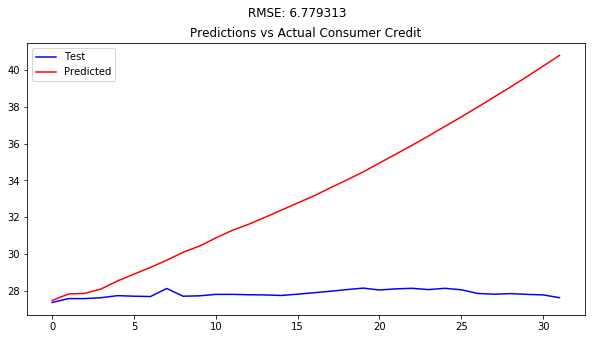

In [27]:
plot_predictions(test, preds, rmse, 'Consumer Credit')

In [28]:
#Fitting rolling forecast ARIMA model

In [29]:
def fit_rolling_arima(train, test):

    history = [x for x in train]
    predictions = list()
    
    #fit rolling ARIMA
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions)) 
    print('Test RMSE: %.3f' % rmse)
    
    return rmse, predictions

In [54]:
len(train)

52

In [30]:
rmse, preds = fit_rolling_arima(train, test)

predicted=27.463795, expected=27.350000
predicted=27.529732, expected=27.560000
predicted=27.743352, expected=27.560000
predicted=27.732652, expected=27.610000
predicted=27.801780, expected=27.720000
predicted=27.875317, expected=27.690000
predicted=27.850543, expected=27.670000
predicted=27.824747, expected=28.110000
predicted=28.253754, expected=27.690000
predicted=27.833131, expected=27.710000
predicted=27.929757, expected=27.790000
predicted=27.859476, expected=27.790000
predicted=27.933265, expected=27.770000
predicted=27.868223, expected=27.760000
predicted=27.876447, expected=27.730000
predicted=27.838451, expected=27.800000
predicted=27.897803, expected=27.880000
predicted=27.970093, expected=27.960000
predicted=28.067607, expected=28.050000
predicted=28.163656, expected=28.130000
predicted=28.253399, expected=28.030000
predicted=28.156775, expected=28.090000
predicted=28.213541, expected=28.120000
predicted=28.205871, expected=28.050000
predicted=28.150553, expected=28.120000


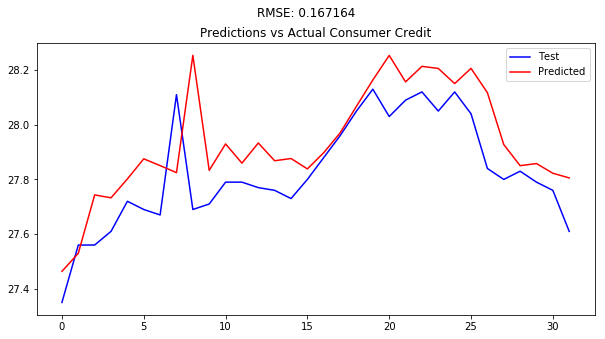

In [31]:
plot_predictions(test, preds, rmse, 'Consumer Credit')

Next we predict ' Deposit interest rate', ' Mortgage credit interest rate', ' Business credit interest rate',

In [32]:
train, test = split_data(df[' Deposit interest rate'], 0.62)
rmse, deposit_pred = fit_rolling_arima(train, test)

predicted=4.150853, expected=4.190000
predicted=4.205970, expected=4.230000
predicted=4.276454, expected=4.520000
predicted=4.580050, expected=4.460000
predicted=4.551885, expected=4.470000
predicted=4.558374, expected=4.650000
predicted=4.677160, expected=4.280000
predicted=4.389433, expected=3.680000
predicted=3.571984, expected=3.220000
predicted=2.734814, expected=2.720000
predicted=2.216322, expected=2.470000
predicted=2.367904, expected=2.200000
predicted=2.036425, expected=2.040000
predicted=1.981708, expected=1.840000
predicted=1.712121, expected=1.790000
predicted=1.746586, expected=1.530000
predicted=1.392408, expected=1.460000
predicted=1.390865, expected=1.490000
predicted=1.445645, expected=1.550000
predicted=1.599593, expected=1.520000
predicted=1.551773, expected=1.410000
predicted=1.365208, expected=1.320000
predicted=1.242077, expected=1.290000
predicted=1.235231, expected=1.230000
predicted=1.188897, expected=1.130000
predicted=1.078496, expected=1.400000
predicted=1.

In [33]:
print('Months in Train Dataset: ', len(train))
print('Months in Test Dataset: ', len(test))

Months in Train Dataset:  52
Months in Test Dataset:  32


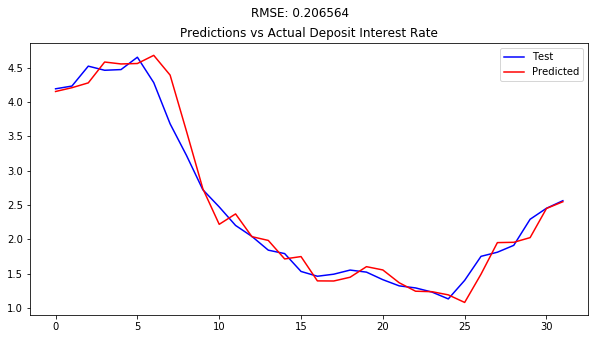

In [34]:
plot_predictions(test, deposit_pred, rmse, 'Deposit Interest Rate')

In [35]:
train, test = split_data(df[' Mortgage credit interest rate'], 0.62)
rmse, mortg_pred = fit_rolling_arima(train, test)

predicted=5.339809, expected=5.450000
predicted=5.450175, expected=5.610000
predicted=5.769076, expected=5.650000
predicted=5.723884, expected=5.710000
predicted=5.751208, expected=5.760000
predicted=5.788253, expected=5.670000
predicted=5.627279, expected=5.720000
predicted=5.778767, expected=4.940000
predicted=4.787147, expected=4.130000
predicted=3.512320, expected=3.450000
predicted=2.810887, expected=3.070000
predicted=2.773320, expected=2.810000
predicted=2.748452, expected=2.650000
predicted=2.596766, expected=2.570000
predicted=2.563390, expected=2.540000
predicted=2.540951, expected=2.390000
predicted=2.282218, expected=2.320000
predicted=2.267595, expected=2.280000
predicted=2.256951, expected=2.260000
predicted=2.237539, expected=2.250000
predicted=2.244769, expected=2.170000
predicted=2.106112, expected=2.200000
predicted=2.217515, expected=2.230000
predicted=2.253033, expected=2.260000
predicted=2.271688, expected=2.310000
predicted=2.346235, expected=2.280000
predicted=2.

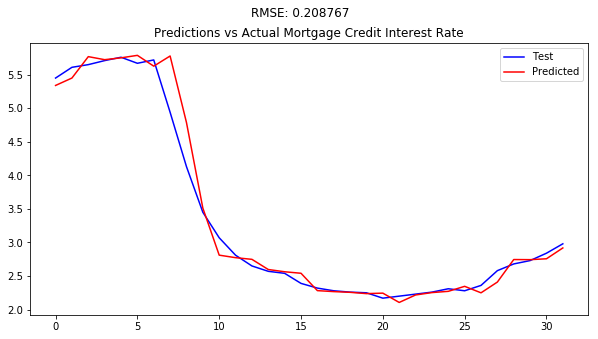

In [37]:
plot_predictions(test, mortg_pred, rmse, 'Mortgage Credit Interest Rate')

In [38]:
train, test = split_data(df[' Business credit interest rate'], 0.62)
rmse, bus_pred = fit_rolling_arima(train, test)

predicted=6.518649, expected=6.800000
predicted=6.772054, expected=6.730000
predicted=6.825735, expected=7.050000
predicted=7.009011, expected=7.030000
predicted=7.015659, expected=7.170000
predicted=7.198371, expected=7.170000
predicted=7.256500, expected=7.050000
predicted=7.119417, expected=6.500000
predicted=6.655078, expected=6.210000
predicted=6.086740, expected=5.490000
predicted=5.086772, expected=5.180000
predicted=4.807849, expected=4.910000
predicted=4.826664, expected=4.920000
predicted=4.927402, expected=4.700000
predicted=4.907984, expected=4.610000
predicted=4.595904, expected=4.290000
predicted=4.234575, expected=4.360000
predicted=4.206266, expected=4.370000
predicted=4.390168, expected=4.130000
predicted=4.104004, expected=4.110000
predicted=4.107846, expected=4.500000
predicted=4.468974, expected=4.170000
predicted=4.218411, expected=4.160000
predicted=4.245649, expected=4.440000
predicted=4.408357, expected=4.490000
predicted=4.374230, expected=4.550000
predicted=4.

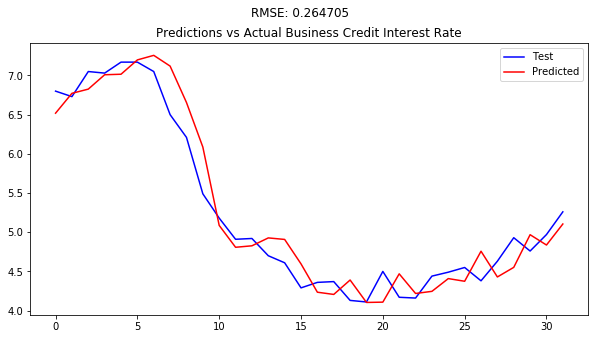

In [39]:
plot_predictions(test, bus_pred, rmse, 'Business Credit Interest Rate')

Next we create a financial simulation using actual and predicted interest rates for the timeframe included in our test dataset

Assuming the bank's revenues are equally split into mortgage and business lending, we define Average Customer CLV with the formula:

Avg Customer CLV = (Mortgage Rate + Business Rate)/2 - Deposit Rate

In [40]:
#Creating df feature defined as Avg Customer CLV:
df['avg_cust_clv'] = ((df[' Mortgage credit interest rate']
                       +df[' Business credit interest rate'])/2)-df[' Deposit interest rate']

In [41]:
_, test_clv = split_data(df['avg_cust_clv'], 0.62)

In [42]:
pred_clv = ((np.array(mortg_pred) + np.array(bus_pred))/2)-np.array(deposit_pred)

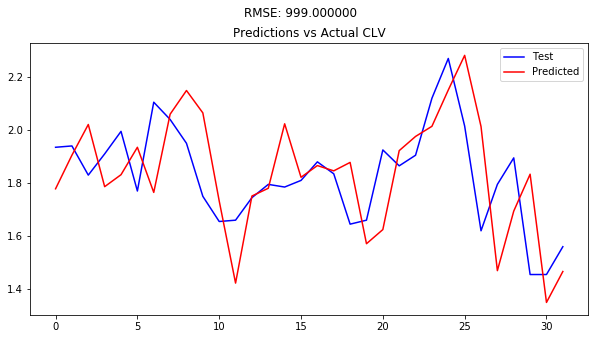

In [43]:
plot_predictions(test_clv, pred_clv, 999, 'CLV')

In [ ]:
#enhancement: create rolling ARIMA that looks farther into the future e.g. + 3 months 
#goal is to reflect campaign duration pre campaign launch

In [571]:
#enhancement: upsample to daily rate to obtain higher profitability

In [572]:
#enhancement: use LSTM neural network to predict interest rates

In [573]:
#enhancement: try predicting the avg clv directly

Final output: prediction for avg customer clv (will be used to choose optimal log regression threshold)

We assume each point differential between mortgage and business, and deposit interest rates will return an average $100 profit per customer

In [44]:
pred_clv = pred_clv*100

In [45]:
start = len(df) - len(pred_clv)

In [46]:
pred_clv_df = df[['Year','Month']].iloc[start:,:].reset_index(drop=1)

In [47]:
pd.DataFrame(pred_clv)

,0
0,177.837551
1,190.514481
2,202.095194
3,178.639744
4,183.154864
5,193.493815
6,176.472957
7,205.965941
8,214.912850
9,206.471588


In [48]:
pred_clv_df['clv_est'] = pd.DataFrame(pred_clv)

In [50]:
%store pred_clv_df

Stored 'pred_clv_df' (DataFrame)


In [51]:
pred_clv_df.sort_values(['Year', 'Month'])

,Year,Month,clv_est
0,2008,5,177.837551
1,2008,6,190.514481
2,2008,7,202.095194
3,2008,8,178.639744
4,2008,9,183.154864
5,2008,10,193.493815
6,2008,11,176.472957
7,2008,12,205.965941
8,2009,1,214.912850
9,2009,2,206.471588
